#### Context

Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow
Content

This dataset contains daily weather observations from numerous Australian weather stations.

The target variable RainTomorrow means: Did it rain the next day? Yes or No.

**Note: You should exclude the variable Risk-MM when training a binary classification model. Not excluding it will leak the answers to your model and reduce its predictability. Read more about it here.
Source & Acknowledgements!**

Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data. Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

This dataset is also available via the R package rattle.data and at https://rattle.togaware.com/weatherAUS.csv.
Package home page: http://rattle.togaware.com. Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data.

And to see some nice examples of how to use this data: https://togaware.com/onepager/


In [1]:
import pandas as pd
import numpy as np

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
import xgboost as xgb

#Common Model Helpers
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection, model_selection, metrics

# Dimensionality Reduction
from sklearn.decomposition import PCA

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.features import RFECV


import scikitplot
from scikitplot.metrics import plot_cumulative_gain

import shap

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
plt.style.use('ggplot')

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\kovus\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\kovus\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Gather Data

In [2]:
def get_data(location='C:/Users/kovus/Documents/Projects/weather_aus/data/weatherAUS.csv'):
    """Download and cache the fremont data
    Parameters
    ----------
    filename: string(optional)
        location to save the data
    url: string(optional)
        web location of the data
    force_download: boolean(optional)
        if True force redownload of data
        
    Returns
    -------
    data: pandas.DataFrame
        Fremont bridge data
    """
# read in the data from local folder
data = pd.read_csv('C:/Users/kovus/Documents/Projects/weather_aus/data/weatherAUS.csv')

# make a copy of retrieved data
df = data.copy()

# take a look at first 5 rows
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [5]:
# drop RISK_MM to prevent data leakage
df.drop(['RISK_MM'], axis=1, inplace=True)

### Check Data

In [3]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df)

In [4]:
# preview information on features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [6]:
# statistical information on features
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


### Explore Data

### Imbalanced Classes

In [ ]:
# how many unique values our features have?
pd.DataFrame({'Feature':df.nunique().index, 'Unique values':df.nunique().values})

In [ ]:
#using crosstabs
for col in df.columns[df.nunique()<20]:
    print('Target Crosstab by:', col)
    print(pd.crosstab(df[col], df['RainTomorrow']))
    print('-'*25, '\n')

In [ ]:
pd.crosstab(df['Location'], df['RainTomorrow'])

In [ ]:
pd.crosstab(df['Location'], df['RainTomorrow'])['No']/(pd.crosstab(df['Location'], df['RainTomorrow'])['No']+pd.crosstab(df['Location'], df['RainTomorrow'])['Yes'])*100

In [ ]:
df.nunique(dropna=False)

In [ ]:
# graph distribution of ordinal(continuous) variables
plt.figure(figsize=(10, 30))
i = 0
for col in df.columns[df.nunique()<20]:
    i += 1
    plt.subplot(910+i)
    plt.title(f'{col} Value Counts')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    sns.countplot(x=col, data=df, orient='v')
    plt.tight_layout();

In [ ]:
for col in df.columns[df.nunique()<20]:
    print(df[col].value_counts(dropna=False)/df.shape[0])

In [ ]:
# # categorical(discrete) variable correlation by using target
# for col in df.columns[df.nunique()<20]:
#     print('Target Correlation by:', col)
#     print(df[[col, 'RainTomorrow']].groupby(col).mean())
#     print('-'*25, '\n')

In [ ]:
len(df.columns[(df.nunique()>20) & (df.dtypes!='object')])

In [ ]:
# # graph distribution of ordinal(continuous) variables
# plt.figure(figsize=(6, 6))
# i = 0
# for col in df.columns[(df.nunique()>20) & (df.dtypes!='object')]:
#     i += 1
#     plt.subplot(350+i)
#     plt.title(f'{col} Distribution Plot')
#     plt.ylabel('?')
#     plt.xticks(rotation=45)
#     sns.kdeplot(data=df[col], shade=True)
#     plt.tight_layout();


In [ ]:
# # boxplots for ordinal(continuous) variables
# plt.figure(figsize=[12, 10])

# i=0
# for col in df.columns[(df.nunique()>20) & (df.dtypes!='object')]:
#     i += 1
#     plt.subplot(550+i)
#     plt.boxplot(x=df[col], showmeans = True, meanline = True)
#     plt.title(f'{col.upper()} Boxplot')
#     plt.ylabel(f'{col.upper()}')

In [ ]:
for col in df.columns[(df.nunique()>20) & (df.dtypes!='object')]:
    sns.kdeplot(data=df[col], shade=True)
    plt.title('Continuous variables before standardization')

### Feature Engineering

In [ ]:
pd.DataFrame({'% Missing':(df.isnull().mean()*100).values, 
              'Data Type':(df.dtypes)}
            ).sort_values('% Missing', ascending=False)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.weekday

In [ ]:
# convert months to seasons
# [(month%12 + 3)//3 for month in range(1, 13)]

In [ ]:
df.drop('Date', axis=1, inplace=True)

In [ ]:
for col in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 
            'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow']:
    df = df.astype({col:'category'})

In [ ]:
# ?????????
# for col in df.select_dtypes(include='object'):
#     df = df.astype({col:'float64'})

In [ ]:
df.dtypes

In [ ]:
df.nunique(dropna=False)

### Sample Data

In [ ]:
# define target vector (y)
y = df['RainTomorrow']

# define features matrix (X)
X = df.drop(['RainTomorrow', 'Location'], axis=1)

In [ ]:
# look at the sizes of features matrix and target vector
print(f'X: {X.shape}, y: {y.shape}')

In [ ]:
# separate categorical features(discrete)
cat_cols = X.columns[X.dtypes=='category']

# separate ordinal columns(continous)
ord_cols = X.columns[X.dtypes!='category']

In [ ]:
print(f'Categorical features:{cat_cols}\nOrdinal features:{ord_cols}')

In [ ]:
def get_sample_data(X=X, y=y):
    """Takes in X and y and performs the following:
    1. One-Hot Encodes(Dummy variables) categorical features
    2. Splits X and y into training and testing sets
    3. Standardizes features for better model performance
    4. Returns X_train, X_test, y_train, y_test
    
    Parameters:
    ----------
    X : Pandas DataFrame(default: user-defined feature matrix)
    y : Pandas Series(defalt: user-defined target vector)
    
    Returns:
    X_train: Pandas DataFrame, X training set
    X_test: Pandas DataFrame, X testing set
    y_train: Pandas Series, y training set
    y_test: Pandas Series, y testing set
    """

    # cast categorical features as type category
    for col in cat_cols:
        X = X.astype({col:'category'})

    # get dummy variables
    X = pd.get_dummies(X, drop_first=True)
    
    # rename dummy columns
    X.rename(columns={'sex_1':'sex_male', 'fbs_1':'fbs_pos', 'exang_1':'exang_pos'}, inplace=True)
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=43)
    
    # standardize training and testing sets separately to avoid data leakage
    sca = StandardScaler()
    X_train.loc[:, ord_cols] = sca.fit_transform(X_train.loc[:, ord_cols])
    X_test.loc[:, ord_cols] = sca.fit_transform(X_test.loc[:, ord_cols])
    
    return X_train, X_test, y_train, y_test

In [ ]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=43)

### Impute Data

In [ ]:
# Are there any missing values?
print('There is(are) {} total missing value(s) in dataset'.format(df.isnull().sum().sum()))

# Are there any duplicated samples?
print('There is(are) {} duplicated row(s) in dataset'.format(df.duplicated().sum()))

#### Fillna

In [ ]:
for df1 in [X_train, X_test]:
    for col in ord_cols:
        col_median=X_train[col].median()
        df1[col].fillna(col_median, inplace=True)
        
for df2 in [X_train, X_test]:
    for col in cat_cols:
        col_mode = X_train[col].mode()[0]
        df2[col].fillna(col_mode, inplace=True)

### Preprocess Data

In [ ]:
# get dummy variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
y_train = pd.get_dummies(y_train, drop_first=True)
y_test = pd.get_dummies(y_test, drop_first=True)

In [ ]:
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

In [ ]:
sca = StandardScaler()
X_train.loc[:, ord_cols] = sca.fit_transform(X_train.loc[:, ord_cols])
X_test.loc[:, ord_cols] = sca.transform(X_test.loc[:, ord_cols])

In [ ]:
for col in ord_cols:
    sns.kdeplot(data=df[col], shade=True)
    plt.title('Continuous variables before standardization')

In [ ]:
for col in ord_cols:
    sns.kdeplot(data=X_train[col], shade=True)
    plt.title('Continuous variables after standardization')

In [ ]:
# concatenate training and testing set after normalization to avoid data leakage
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.shape, y.shape

### Ordinal Values

### Correlation

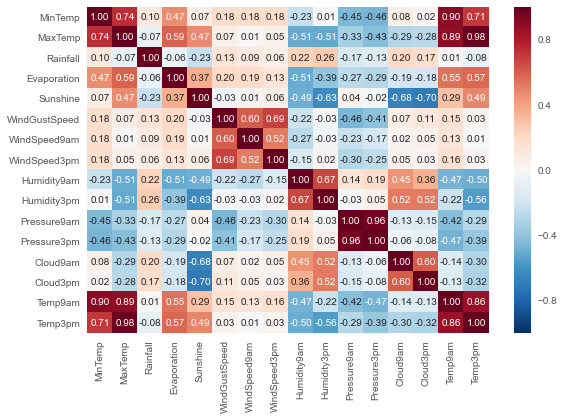

In [9]:
# correlation among ordinal(continuous) variables
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df.corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1);

In [ ]:
# correlation among ordinal(continuous) variables
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(X.loc[:, ord_cols].corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1);

**Inference:** 


In [ ]:
# sns.pairplot(X.loc[:, ord_cols]);

**Inference:** 


### Parallel Coordinates

Parallel Coordinates visualization makes it easy to see clusters of data in individual variables.

In [ ]:
from yellowbrick.features import ParallelCoordinates

In [ ]:
# # missing values??

# fig, ax = plt.subplots(figsize=(6, 6))
# pc = ParallelCoordinates(classes=['No Rain', 'Rain'], features=ord_cols, alpha=0.25)
# pc.fit(df[ord_cols], y)
# pc.transform(df[ord_cols])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# pc.poof();

In [ ]:
# graph distribution of ordinal(continuous) variables
plt.figure(figsize=(16, 10))
i = 0
for col in ord_cols:
    i += 1
    a = sns.FacetGrid(df, hue = 'RainTomorrow', aspect=4 )
    a.map(sns.kdeplot, col, shade= True )
    a.set(xlim=(df[col].min()-2*df[col].std() , df[col].max()+2*df[col].std()))
    a.add_legend()

plt.tight_layout();

**Inference:**



## Model Building

### Baseline Model

As a baseline model we will utilize Dummy Classifier, which we will then use for comparison.

https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

In [ ]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

In [ ]:
print('Precision score:', metrics.precision_score(y_test, dc.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, dc.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, dc.predict(X_test)))

In [ ]:
# from sklearn.metrics import classification_report

# print(classification_report(y_test, y_pred_test))

### Various Families

We will take a look at different classifiers below:

In [ ]:
for model in [DummyClassifier,
#               linear_model.LogisticRegression,
#               tree.DecisionTreeClassifier,
#               neighbors.KNeighborsClassifier,
#               naive_bayes.GaussianNB,
#               svm.SVC,
              ensemble.RandomForestClassifier,
#               xgb.XGBClassifier
             ]:
    classifier = model()
    kfold = model_selection.KFold(n_splits=10, random_state=43)
    score = model_selection.cross_val_score(classifier, X, y, scoring='roc_auc', cv=kfold)
    print(f'{model.__name__:25}'
          f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

Top 3 scorers are:
1. Logistic Regression
2. Gaussian NB
3. Decision Tree

We will take a look at them in same order.

### Stacking

We will try out stacking and see if it improves the score.

In [ ]:
# from mlxtend.classifier import StackingClassifier

# classifiers = [x() for x in [DummyClassifier,
#                              linear_model.LogisticRegression,
#                              tree.DecisionTreeClassifier,
#                              neighbors.KNeighborsClassifier,
#                              naive_bayes.GaussianNB,
#                              svm.SVC,
#                              ensemble.RandomForestClassifier,
#                              xgb.XGBClassifier
#                             ]
#               ]

# # meta_classifier???
# stc = StackingClassifier(classifiers=classifiers, meta_classifier=linear_model.LogisticRegression())
# score = model_selection.cross_val_score(stc, X, y, scoring='roc_auc', cv=kfold)
# print(f'stc.__name__:'
#       f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

Stacking the classifiers didn't improve the score. We will not proceed with stacked classifier.

### Logistic Regression

In [ ]:
X_train.isnull().sum().sum()

In [ ]:
logr = linear_model.LogisticRegression(random_state=43)
logr.fit(X_train, y_train)

In [ ]:
logr.score(X_test, y_test)

In [ ]:
print('Precision score:', metrics.precision_score(y_test, logr.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, logr.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, logr.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, logr.predict(X_test)))

In [ ]:
# Feature importance
print('Feature Importances:')
for col, val in sorted(zip(X.columns, logr.coef_[0]),
                       key=lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10}{val:10.3f}')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
logr_fi = FeatureImportances(logr)
logr_fi.fit(X, y)
logr_fi.poof();

#### Learning Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = model_selection.StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
logr_lc = LearningCurve(logr, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
logr_lc.fit(X, y)
logr_lc.poof();

Inference:

Learning curve shows us that our Logistic Regression Classifier is **performing quite well**. Difference between Training and Cross Validation Scores is minimizing with more data.

#### Cumulative Gains Plot

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = logr.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

Cumulative Gains plot is used to evaluate a binary classifier. It models the true positive rate(sensitivity) agains the support rate(fraction of positive predictions. **INSERT REFERENCE HERE**

This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 99% of sick patients.**

### Support Vector Classifier

In [ ]:
svc = svm.SVC(random_state=43, probability=True)
svc.fit(X_train, y_train)

In [ ]:
svc.score(X_test, y_test)

In [ ]:
print('Precision score:', metrics.precision_score(y_test, svc.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, svc.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, svc.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, svc.predict(X_test)))

#### Learning Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = model_selection.StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
svc_lc = LearningCurve(svc, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
svc_lc.fit(X, y)
svc_lc.poof();

**Inference:**

Learning curve shows us that our Support Vector Classifier is suffering from high variance(overfitting). Depending on the costs, **gathering more data** will likely improve the Cross Validation Score and prevent overfitting.

#### Cumulative Gains Plot

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = svc.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 98% of sick patients.**

### Random Forest Classifier

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=43)
rf.fit(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
print('Precision score:', metrics.precision_score(y_test, rf.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, rf.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, rf.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, rf.predict(X_test)))

In [ ]:
# Feature Importances
print('Feature Importances:')
for col, val in sorted(zip(X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10} {val:10.3f}')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
rf_fi = FeatureImportances(rf)
rf_fi.fit(X, y)
rf_fi.poof();

### Optimize Model

Below we will tune hyperparameters of our Random Forest classifier and attempt to increase model's accuracy.

In [ ]:
# rf_test = ensemble.RandomForestClassifier(random_state=43)
# params = {'max_features': [0.4, 'auto'],
#           'n_estimators': [15, 200],
#           'min_samples_leaf': [1, 0.1],
#           'random_state': [43]
#          }
# cv = model_selection.GridSearchCV(rf, params, n_jobs=-1).fit(X_train, y_train)
# print(cv.best_params_)

In [ ]:
# rf_best = ensemble.RandomForestClassifier(**{'max_features': 'auto',
#                                              'n_estimators': 200,
#                                              'min_samples_leaf': 0.1,
#                                              'random_state': 43
#                                             })
# rf_best.fit(X_train, y_train)

In [ ]:
# print('Precision score:', metrics.precision_score(y_test, rf_best.predict(X_test)))
# print('ROC_AUC score:', metrics.roc_auc_score(y_test, rf_best.predict(X_test)))
# print('F1 score:', metrics.f1_score(y_test, rf_best.predict(X_test)))
# print('Matthews score:', metrics.matthews_corrcoef(y_test, rf_best.predict(X_test)))

Slight improvement of accuracy has been reached after hyperparameter tuning.

#### Learning Curve

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 6))
# cv = model_selection.StratifiedKFold(12)
# sizes = np.linspace(0.3, 1.0, 10)
# lc_viz = LearningCurve(rf_best, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
# lc_viz.fit(X, y)
# lc_viz.poof();

**Inference:**

Learning curve shows us that our Random Forest Classifier might be suffering from high bias(underfitting) since both Training and Cross Validation Scores are lower than Logistic Classifier's scores. Depending on the importance of ~5% accuracy, **more complex(polynomial features) models or using more features** might fix our underfitting problem.

#### Cumulative Gains Plot

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 6))
# y_probas = rf_best.predict_proba(X_test)
# scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

Cumulative Gains plot is used to evaluate a binary classifier. It models the true positive rate(sensitivity) agains the support rate(fraction of positive predictions. **INSERT REFERENCE HERE**

This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 98% of sick patients.**

In [ ]:
# shap.initjs()

# s = shap.TreeExplainer(rf_best)
# shap_vals = s.shap_values(X_test)
# shap.force_plot(s.expected_value[0],
#                 shap_vals[0][3, :],
#                 feature_names=X.columns
#                )


In [ ]:
# shap.dependence_plot('age',
#                      shap_vals[0],
#                      X_test,
#                      feature_names=X_test.columns,
#                      alpha=0.5
#                     )

In [ ]:
# shap.dependence_plot('oldpeak',
#                      shap_vals[0],
#                      X_test,
#                      feature_names=X_test.columns,
#                      alpha=0.5
#                     )

In [ ]:
# shap.dependence_plot('chol',
#                      shap_vals[0],
#                      X_test,
#                      feature_names=X_test.columns,
#                      alpha=0.5
#                     )

In [ ]:
# shap.dependence_plot('trestbps',
#                      shap_vals[0],
#                      X_test,
#                      feature_names=X_test.columns,
#                      alpha=0.5
#                     )

In [ ]:
# shap.summary_plot(shap_vals[0], X_test)

## Feature Selection

### RFE

In [ ]:
fig, ax = plt.subplots(figsize=(8 ,8))
rfe = RFECV(ensemble.RandomForestClassifier(n_estimators=100), cv=5)
rfe.fit(X, y)
rfe.poof();

In [ ]:
rfe.rfe_estimator_.ranking_

In [ ]:
rfe.rfe_estimator_.n_features_

In [ ]:
X.columns[rfe.rfe_estimator_.support_]

**Inference:**

Recursive Feature Elimination showed that **21 out of 22 features we have in our dataset are essential in predicting the outcome.** Thus, we cannot drop them.

### PCA

In [ ]:
# pca = PCA(random_state=43)
# X_pca = pca.fit_transform(X)

# pca.explained_variance_ratio_

In [ ]:
# pca.components_[0]

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(pca.explained_variance_ratio_)
# ax.set(xlabel='Component',
#        ylabel='% of Explained Variance',
#        title='Scree Plot',
#        ylim=(0, 1),
#        xlim=(0, 10)
#       );

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot(np.cumsum(pca.explained_variance_ratio_))
# ax.set(xlabel='Component',
#        ylabel='% of Explained Variance',
#        title='Cumulative Variance',
#        ylim=(0, 1)
#       );

**Inference:**

Cumulative Variance plot showes that if we can **keep 80% variance if we use 6 PCA components.**

Plot below will show how much do features impact our components.

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.imshow(pca.components_.T,
#            cmap='Spectral',
#            vmin=-1,
#            vmax=1          
#           )
# plt.yticks(range(X.shape[1]), X.columns)
# plt.xticks(range(X.shape[1]), range(1, X.shape[1]+1))
# plt.xlabel('Principal Component')
# plt.ylabel('Contribution')
# plt.title('Contribution of Features to Components')
# plt.colorbar();